# Experiment templates
**Author: Hafsa Bousbiat**


NILMtk is toolkit offering a variety of tools for scholars to help them analyse NILM datasets. The recently introduced API made it very easy for users to interact with the toolkit and perform experiments using different experimental setups. However, the use of different setups in different papers makes it difficult to compare and analyse the results that are obtained in order to have a fair benchmarking.  Fo this reason, the deep-nilmtk takes the pipeline automation a step further and offer a pre-configured **templates for the experiments**. The current version contain only one template for the ukdale. However, this componenet is flexible and subject to extension for scholars to share their designs and encourage a standard/common experimental setups that allow for **direct comparison** and **easy benchmarking**.


The current notebook uses  the **ukdale template** to train the washing machine. For demonstartion purposes, we will only use a single baseline, the Seq2Point baseline. The ukdale experiment template is a NILMtk experiment with three months of training and one month of testing on the the building 1. The sample rate used is an 8 seconds. 

In [5]:
from deep_nilmtk.disaggregator import NILMExperiment
from deep_nilmtk.models.pytorch import UNETNILM
from deep_nilmtk.data.loader.pytorch import GeneralDataLoader
from deep_nilmtk.utils.templates import ExperimentTemplate

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from pathlib import Path


### HIPE

In [6]:
DATA_PATH = '../../data/'
EXPERIMENT_NAME = 'hipe_with_baselines'
RESULTS_PATH = '../../results/hipe/hipe_with_baselines'

### REDD

In [6]:
DATA_PATH = '../../data/'
EXPERIMENT_NAME = 'redd_with_baselines'
RESULTS_PATH = '../../results/redd/hipe_with_baselines'

## Template Initialization

In [5]:
model_config ={
    'in_size': 121,
    'out_size': 1,
    'max_nb_epochs': 1
}

template = ExperimentTemplate( data_path=DATA_PATH,
                 template_name='redd_acts_from_paper',
                 list_appliances=['washing machine'],
                 list_baselines_backends=[('Seq2Pointbaseline', 'pytorch')],
                 model_config = model_config)

## Custom model

In [11]:
unet_nilm = NILMExperiment({
                "model_class": UNETNILM,
                "loader_class": GeneralDataLoader,
                "model_name": 'unet101',
                'backend':'pytorch',
                'in_size': 121,
                'out_size':1,
                'custom_preprocess':None,
                'feature_type':'mains',
                'input_norm':'z-norm',
                'target_norm':'z-norm',
                'seq_type':'seq2point',
                'point_position':'mid_position',
                'learning_rate':10e-5,
                'max_nb_epochs': 1
                })

## Extending the template

In [ ]:
template.extend_experiment({
    'unet101':unet_nilm
})

template.__print__()

## Running the experiment

In [3]:
EXPERIMENT_NAME

'redd_with_baselines'

In [4]:
RESULTS_PATH

'../../redd_with_baselines'

In [ ]:
template.run_template(EXPERIMENT_NAME,
                     RESULTS_PATH,
                     f'{RESULTS_PATH}/mlflow')

Started training for  Seq2Pointbaseline
Joint training for  Seq2Pointbaseline
............... Loading Data for training ...................
Loading data for  redd  dataset


## Check the results

The results directory will contain several artifacts. Analysing the results of an experiment can be done either using mlflow for a detailed tracking and logging of the training process or for comparison between the current results and previous experiments of the user. The second option to just check the final output of teh current expeiment is to load the results from a pickle file holding the name of the experiment that can be also found in the specified results path. 

For the current notebook, we only check the pickle file and have a closer look at the generated predictions.

In [4]:
with open(f'{RESULTS_PATH}/{EXPERIMENT_NAME}.p', 'rb') as f:
    results = pickle.load(f)
results.keys()

dict_keys(['error_keys', 'errors', 'train_mains', 'train_submeters', 'test_mains', 'test_submeters', 'gt', 'predictions', 'execution_time'])

In [5]:
wm_results=pd.DataFrame({
    key: results['predictions'][key].values.reshape(-1) for key in results['predictions']
}, index= results['test_submeters'][0][1][0].index)
wm_results['True consumption']= results['test_submeters'][0][1][0].values

wm_results.head()

,Seq2Pointbaseline,True consumption
2011-04-18 09:22:12-04:00,1.064938,0.0
2011-04-18 09:22:18-04:00,1.064938,0.0
2011-04-18 09:22:24-04:00,1.064938,0.0
2011-04-18 09:22:30-04:00,1.064938,0.0
2011-04-18 09:22:36-04:00,1.064938,0.0


In [ ]:
import plotly.express as px

px.scatter(wm_results).show()

<Axes: >

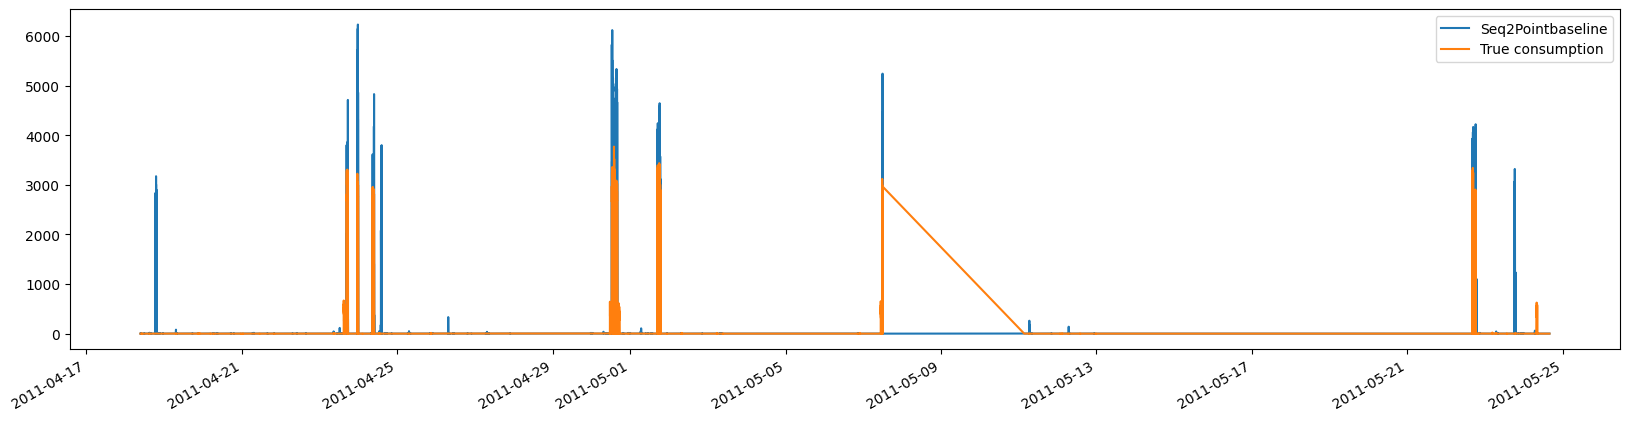

In [7]:
wm_results.plot(figsize=(20,5))

Cool!! We obtained the results of the experiment. Let's now zoom a bit and look at one activation.

<Axes: >

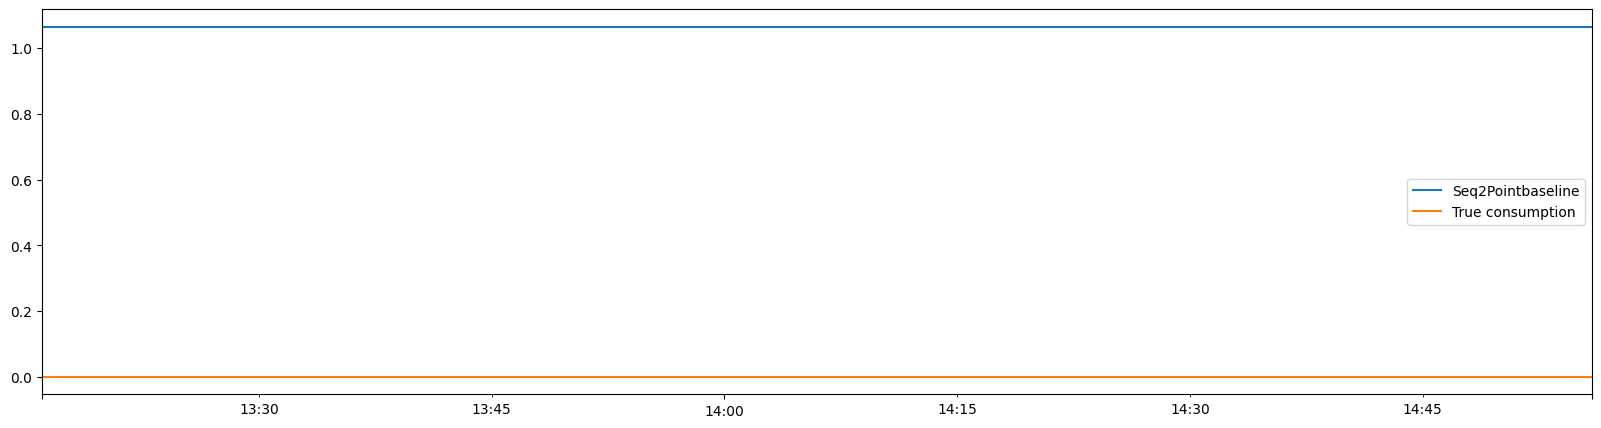

In [9]:
wm_results.iloc[16700:17700].plot(figsize=(20,5))